# 0. Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import matplotlib.pyplot as plt

In [2]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# 1. Dataset

https://www.kaggle.com/datasets/validmodel/grocery-store-dataset/data

In [3]:
data_dir = "../data/GroceryStoreDataset/dataset"

img_size = (180, 180)
batch_size = 32
seed = 42

In [4]:
df_classes = pd.read_csv(data_dir + "/classes.csv")
df_classes.sample(5)

,Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
49,Alpro-Blueberry-Soyghurt,49,Soyghurt,25,/iconic-images-and-descriptions/Packages/Soygh...,/iconic-images-and-descriptions/Packages/Soygh...
45,Oatly-Oat-Milk,45,Oat-Milk,22,/iconic-images-and-descriptions/Packages/Oat-M...,/iconic-images-and-descriptions/Packages/Oat-M...
42,Garant-Ecological-Medium-Fat-Milk,42,Milk,20,/iconic-images-and-descriptions/Packages/Milk/...,/iconic-images-and-descriptions/Packages/Milk/...
14,Watermelon,14,Melon,7,/iconic-images-and-descriptions/Fruit/Melon/Wa...,/iconic-images-and-descriptions/Fruit/Melon/Wa...
56,Valio-Vanilla-Yoghurt,56,Yoghurt,27,/iconic-images-and-descriptions/Packages/Yoghu...,/iconic-images-and-descriptions/Packages/Yoghu...


In [5]:
coarse_mapping = dict(df_classes[["Coarse Class ID (int)", "Coarse Class Name (str)"]].drop_duplicates().values)

In [6]:
filter_img = [0,1,2]

In [7]:
coarse_mapping = {k: v for k, v in coarse_mapping.items() if k in filter_img}
coarse_mapping

{0: 'Apple', 1: 'Avocado', 2: 'Banana'}

In [8]:
df_train = pd.read_csv(data_dir + "/train.txt",names= ['path','fine','coarse'])
df_val = pd.read_csv(data_dir + "/val.txt",names= ['path','fine','coarse'])
df_test = pd.read_csv(data_dir + "/test.txt",names= ['path','fine','coarse'])

In [9]:
df_train = df_train[df_train.coarse.isin(filter_img)]
df_val = df_val[df_val.coarse.isin(filter_img)]
df_test = df_test[df_test.coarse.isin(filter_img)]

In [10]:
df_train.sample(5)

,path,fine,coarse
140,train/Fruit/Apple/Pink-Lady/Pink-Lady_037.jpg,2,0
39,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0
53,train/Fruit/Apple/Granny-Smith/Granny-Smith_00...,1,0
148,train/Fruit/Apple/Pink-Lady/Pink-Lady_045.jpg,2,0
201,train/Fruit/Apple/Red-Delicious/Red-Delicious_...,3,0


In [11]:
image  = cv2.imread(data_dir + '/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg')
image.shape

(348, 348, 3)

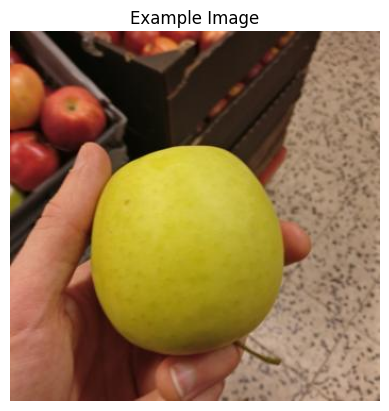

In [12]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Example Image")
plt.axis("off")
plt.show()

In [13]:
df_train["coarse_name"] = df_train["coarse"].map(coarse_mapping)
counts = df_train["coarse_name"].value_counts()

In [52]:
counts

coarse_name
Apple      278
Banana      45
Avocado     41
Name: count, dtype: int64

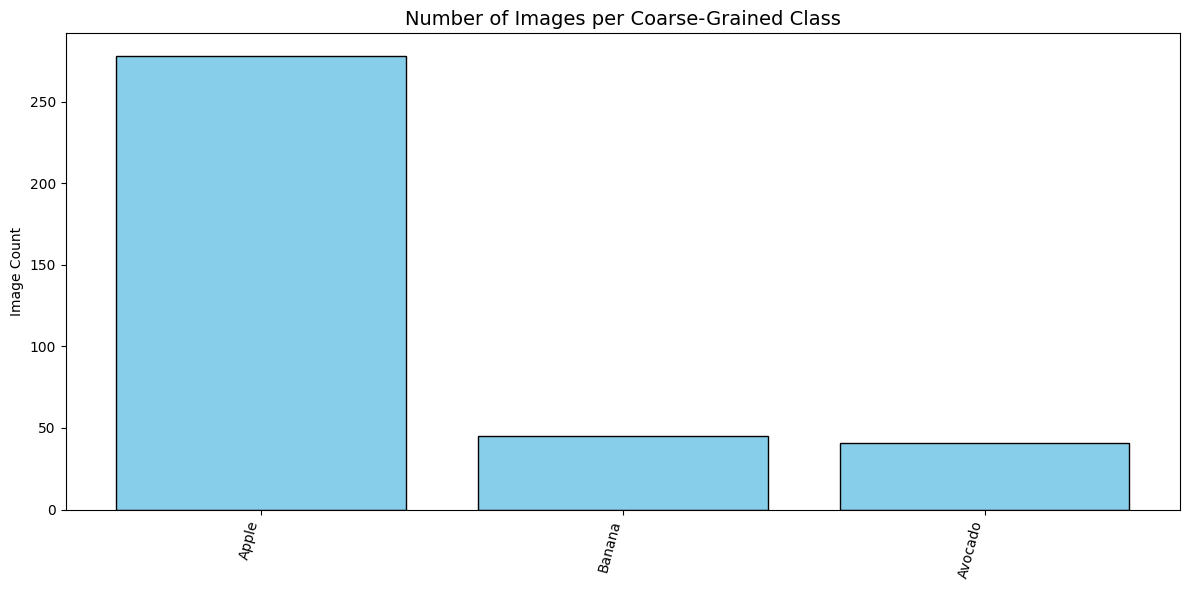

In [14]:
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values, color="skyblue", edgecolor="black")
plt.title("Number of Images per Coarse-Grained Class", fontsize=14)
plt.ylabel("Image Count")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

# 2. Load Dataset with Train/Val/Test

In [15]:
def load_images_from_folder(paths):
    image_ds = []
    for path in paths:
        s = data_dir + '/' + path
        img = cv2.imread(s)
        resized = cv2.resize(img,img_size)
        image_ds.append(resized)
        
    image_array = np.array(image_ds)
    X = image_array/255
    return X

In [16]:
X_train = load_images_from_folder(df_train['path'].values)
X_val = load_images_from_folder(df_val['path'].values)
X_test = load_images_from_folder(df_test['path'].values)

In [17]:
X_train.shape

(364, 180, 180, 3)

In [18]:
X_val.shape

(33, 180, 180, 3)

In [19]:
X_test.shape

(360, 180, 180, 3)

In [20]:
y_train = np.array(df_train['coarse'])
y_val = np.array(df_val['coarse'])
y_test = np.array(df_test['coarse'])

In [21]:
train_counts = dict(zip(counts.index, counts.values))

In [22]:
train_counts

{'Apple': 278, 'Banana': 45, 'Avocado': 41}

In [23]:
# Balance dataset

In [24]:
class_counts = Counter(y_train)
print("Distribución de clases original:")
print(class_counts)

Distribución de clases original:
Counter({0: 278, 2: 45, 1: 41})


In [25]:
max_count = max(class_counts.values())

In [26]:
# --- 2. Crear generador de data augmentation ---
datagen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [27]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [28]:
np.unique(y_train)

array([0, 1, 2])

In [29]:
# --- 3. Oversampling dinámico ---
X_aug = []
y_aug = []

In [30]:
for cls in np.unique(y_train):
    idx = np.where(y_train == cls)[0]
    X_cls = X_train[idx]
    n_current = len(X_cls)
    n_to_generate = 1500 #max_count - n_current
    
    if n_to_generate > 0:
        print(f"Clase {cls}: generando {n_to_generate} imágenes aumentadas")
        gen = datagen.flow(X_cls, batch_size=1)
        
        for i in range(n_to_generate):
            new_img = next(gen)[0]
            X_aug.append(new_img)
            y_aug.append(cls)

Clase 0: generando 1500 imágenes aumentadas
Clase 1: generando 1500 imágenes aumentadas
Clase 2: generando 1500 imágenes aumentadas


In [31]:
# --- 4. Combinar dataset original + aumentado ---
if X_aug:
    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    X_train_balanced = np.concatenate([X_train, X_aug], axis=0)
    y_train_balanced = np.concatenate([y_train, y_aug], axis=0)
else:
    X_train_balanced, y_train_balanced = X_train, y_train

print("\nDistribución balanceada final:")
print(Counter(y_train_balanced))


Distribución balanceada final:
Counter({0: 1778, 2: 1545, 1: 1541})


In [32]:
# Generate a random permutation of indices
permutation = np.random.permutation(len(X_train_balanced))

# Apply the permutation to both X and y
X_train_balanced = X_train_balanced[permutation]
y_train_balanced = y_train_balanced[permutation]

In [33]:
permutation

array([2299, 4666, 1984, ..., 1636, 1551,  279])

# 3. Data Augmentation

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.2),
    #layers.RandomContrast(0.15),
    #layers.RandomBrightness(0.15),
])


I0000 00:00:1764279481.933744    6567 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13746 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:07:00.0, compute capability: 8.9


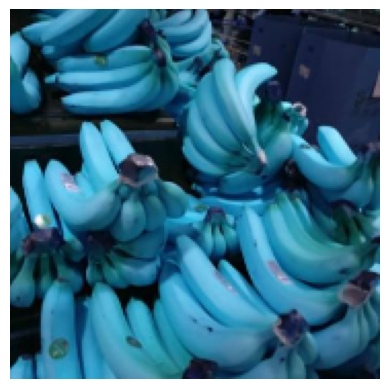

In [35]:
plt.axis('off')
plt.imshow(X_train[360])

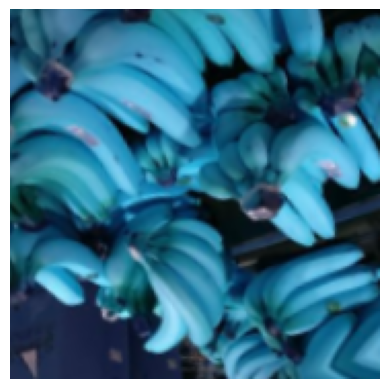

In [36]:
plt.axis('off')
plt.imshow(data_augmentation(X_train)[360])

In [37]:
num_classes = len(coarse_mapping)
num_classes

3

In [55]:
img_size + (3,)

(180, 180, 3)

# 4. Define CNN Model

In [38]:
model = models.Sequential([
    layers.Input(shape=img_size + (3,)),

    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# 5. Compile Model

In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy'
    ]
)

# 6. Train Model

In [40]:
y_train_balanced

array([1, 2, 1, ..., 0, 0, 1])

In [41]:
num_epochs = 100

history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=num_epochs,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=3)
    ]
)

2025-11-27 15:38:05.015100: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1891123200 exceeds 10% of free system memory.
2025-11-27 15:38:06.593886: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1891123200 exceeds 10% of free system memory.


Epoch 1/100


I0000 00:00:1764279489.523398    6928 service.cc:152] XLA service 0x7c9aa4095a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764279489.523424    6928 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-11-27 15:38:09.587843: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764279489.964092    6928 cuda_dnn.cc:529] Loaded cuDNN version 91001
2025-11-27 15:38:11.736122: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1733', 16 bytes spill stores, 16 bytes spill loads

2025-11-27 15:38:11.845657: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

 10/152 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2825 - loss: 1.2833

I0000 00:00:1764279496.463176    6928 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.3432 - loss: 1.1529 - val_accuracy: 0.2121 - val_loss: 1.1376 - learning_rate: 1.0000e-05
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4304 - loss: 1.0564 - val_accuracy: 0.3030 - val_loss: 1.0589 - learning_rate: 1.0000e-05
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4197 - loss: 1.0438 - val_accuracy: 0.6667 - val_loss: 0.8350 - learning_rate: 1.0000e-05
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4398 - loss: 1.0327 - val_accuracy: 0.7273 - val_loss: 0.5809 - learning_rate: 1.0000e-05
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4356 - loss: 1.0255 - val_accuracy: 0.7576 - val_loss: 0.5197 - learning_rate: 1.0000e-05
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4370 - loss: 1.0265 - val_accuracy: 0.8485 - val_loss: 0.3969 - learning_rate: 1.0000e-05
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accurac

In [42]:
model.save("./models/cnn_grocery_store.h5")

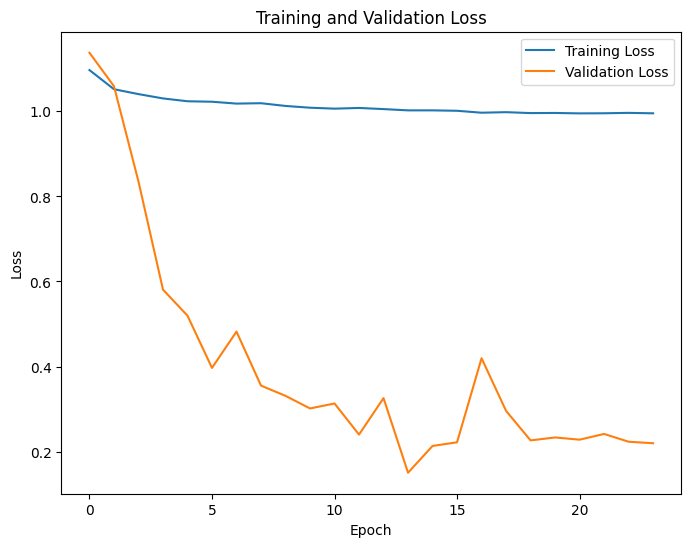

In [43]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 8. F1 Score & Classification Report

In [44]:
y_probs = model.predict(X_test)
y_preds = np.argmax(y_probs, axis=1)

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  

2025-11-27 15:39:32.754800: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_140', 8 bytes spill stores, 8 bytes spill loads



12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step


In [45]:
y_probs

array([[8.4632444e-01, 2.0069277e-04, 1.5347493e-01],
       [7.0000190e-01, 7.7556144e-03, 2.9224241e-01],
       [3.7064582e-01, 6.4240186e-04, 6.2871182e-01],
       ...,
       [4.1269056e-02, 8.5578184e-04, 9.5787513e-01],
       [5.1244622e-01, 2.3744644e-03, 4.8517931e-01],
       [5.9900892e-01, 2.4188289e-03, 3.9857227e-01]], dtype=float32)

In [46]:
y_preds

array([0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1,

In [47]:
f1 = f1_score(y_test, y_preds, average='weighted')
print(f"\nWeighted F1 Score: {f1:.4f}")


Weighted F1 Score: 0.8489


In [48]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       276
           1       0.73      0.82      0.78        40
           2       0.54      0.64      0.58        44

    accuracy                           0.84       360
   macro avg       0.73      0.78      0.75       360
weighted avg       0.86      0.84      0.85       360



# 9. Confusion Matrix

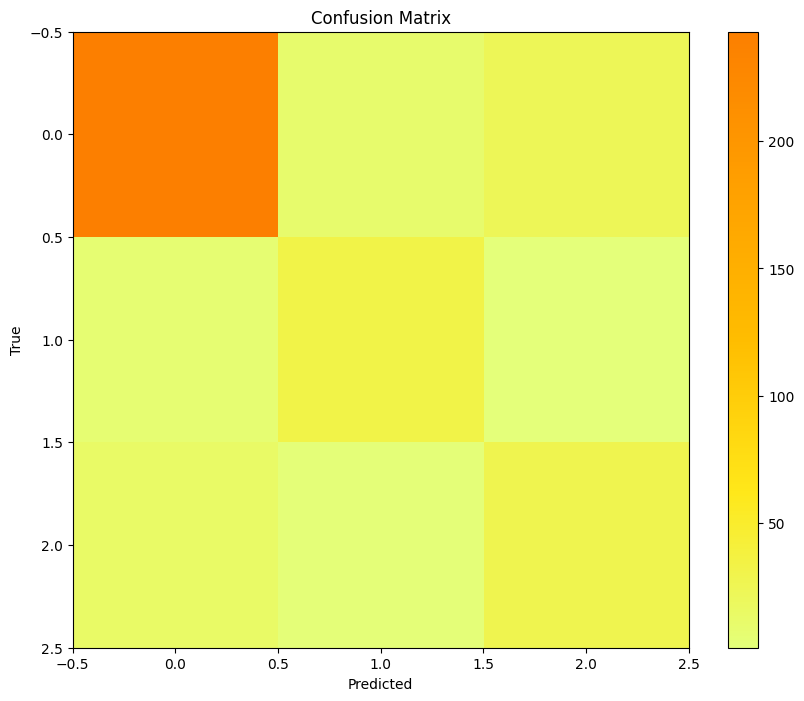

In [49]:
cm = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Wistia')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

In [50]:
cm

array([[243,  10,  23],
       [  6,  33,   1],
       [ 14,   2,  28]])